In [1]:
import os
import sys

import polars as pl
import numpy as np
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

In [2]:
# 約定履歴21日分を読み込む
days = 21
symbol = "BTCUSDT"

# 指定日から30日前までのデータを使いたい場合
last_date = date(year=2023, month=3, day=31)
# 昨日から30日前までのデータを使いたい場合
# last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

if "df_trades" in globals():
    del df_trades
df_trades = None

date_cursor = start_date
while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")
df_trades.describe()

describe,symbol,timestamp,first_update_id,last_update_id,side,update_type,price,qty,pu
str,str,f64,f64,f64,str,str,f64,f64,f64
"""count""","""143495088""",1.43495088e8,1.43495088e8,1.43495088e8,"""143495088""","""143495088""",1.43495088e8,1.43495088e8,1.43495088e8
"""null_count""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0
"""mean""",null,1.6793e12,3.4487e9,3.4487e9,null,null,25951.711845,0.00078,3.4487e9
"""std""",null,5.2641e8,4.1540e7,4.1540e7,null,null,2596.94082,0.607658,4.1540e7
"""min""","""BTCUSDT""",1.6784e12,3.3767e9,3.3767e9,"""a""","""trade""",19521.6,-510.209,3.3767e9
"""max""","""BTCUSDT""",1.6803e12,3.5206e9,3.5206e9,"""b""","""trade""",29184.8,526.769,3.5206e9
"""median""",null,1.6792e12,3.4488e9,3.4488e9,null,null,27149.4,0.001,3.4488e9
"""25%""",null,1.6788e12,3.4126e9,3.4126e9,null,null,24560.0,-0.02,3.4126e9
"""75%""",null,1.6797e12,3.4847e9,3.4847e9,null,null,27921.1,0.02,3.4847e9


In [17]:
# タイムバーを作成
groupby_interval_min = 15
groupby_interval = groupby_interval_min * 60 * 1000

df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("Open"), pl.col("price").max().alias("High"), pl.col("price").min().alias("Low"), pl.col("price").last().alias("Close"), np.abs(pl.col("qty")).sum().alias("Volume"), pl.col("qty").sum().alias("qty_sum"), (pl.col("price").std() / np.sqrt(60)).alias("real_sigma")])
df_timebar = df_timebar.with_columns([((pl.col("Close") - pl.col("Open")) / pl.col("Open")).alias("pct_change_price"), (pl.col("Close") - pl.col("Open")).alias("delta_price")])

# OK Estimatorを利用してボラティリティを推定
def OK_Estimator(open, high, low, close, duration_sec):
    return (0.811 * (high - low) - 0.369 * np.abs(close - open)) / np.sqrt(duration_sec)
df_timebar = df_timebar.with_columns([OK_Estimator(pl.col("Open"), pl.col("High"), pl.col("Low"), pl.col("Close"), groupby_interval / 1000).alias("estimated_sigma")])



argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: invalid value encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


_popt = [3.66447183e+01 1.22613802e-02]


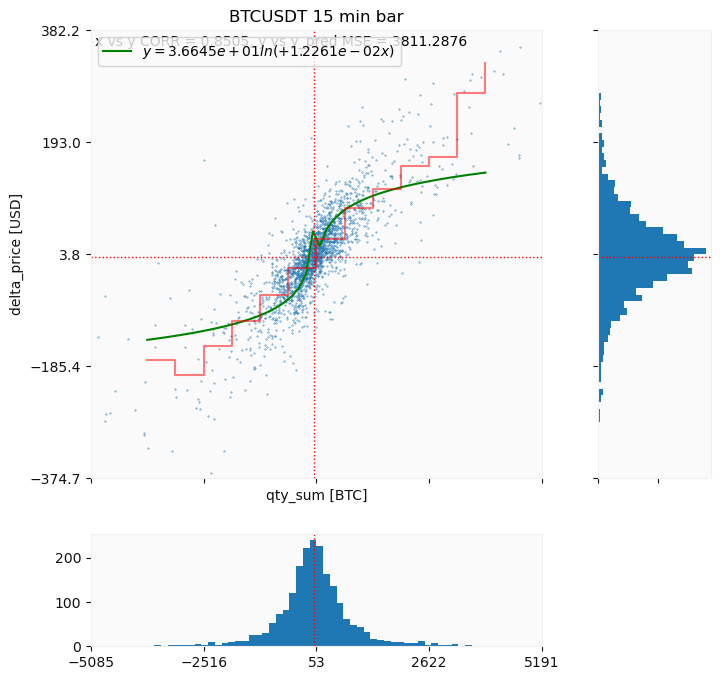

In [18]:
# タイムバーの売買インバランス対価格変化の散布図を作成し、後に使うパラメータb, cを計算する
# _popt[0]がb, _popt[1]がcに相当する
x = df_timebar["qty_sum"]
y = df_timebar["delta_price"]

def func(x, a, b):
    return np.where(np.abs(x) < 1, 0, np.sign(x) * a * np.log(b * np.abs(x)))
func_str = "$y = %s ln(%s x)$"

plot_correlation(x, y, func=func, func_label=func_str, title=f"{symbol} {groupby_interval_min} min bar", xaxis_label="qty_sum [BTC]", yaxis_label="delta_price [USD]", legend_loc="best")

_popt = [31.25918265  0.81996346]


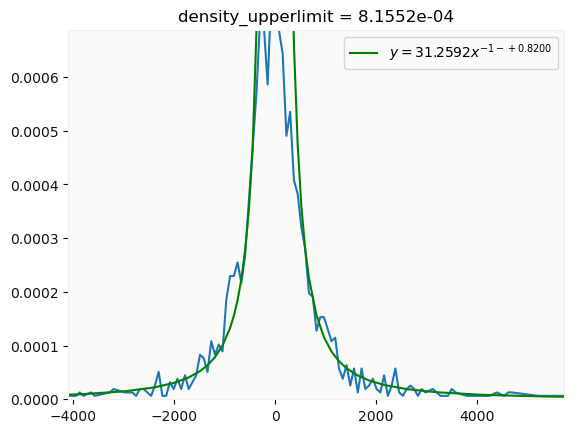

In [28]:
# タイムバーの売買インバランスの確率分布図を作成し、後に使うパラメータa, \alphaを計算する
# _popt[0]がa, _popt[1]が\alphaに相当する
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_quantile = 0.90
density_upperlimit = np.quantile(array_histogram[0], density_quantile)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)

def func(x, a, b):
    return a * np.power(np.abs(x), -1-b)
    
_popt, _pcov = curve_fit(func, df_histogram["qty_sum"], df_histogram["density"])
print(f"_popt = {_popt}")

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_upperlimit = np.quantile(array_histogram[0], 1.0)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)
plt.plot(df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], func(df_histogram["qty_sum"], *_popt), color = 'green', label = '$y = %s x^{-1 - %s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, df_histogram["density"].quantile(0.97))
plt.xlim(df_histogram["qty_sum"].quantile(0.1), df_histogram["qty_sum"].quantile(0.9))
plt.title(f"density_upperlimit = {density_upperlimit:.4e}")
plt.grid()
plt.legend()

$f^Q (x) = a\cdot x^{-1-\alpha}$

$$
a=0.3396702 \\
\alpha=0.14791845 \\
$$

$\Delta p = b\cdot\log(c\cdot Q)$

$$
b=11.11420511\\
c=0.05961304
$$

$\Lambda = \frac{1}{15 \cdot 60}$ (15分を基準時間とするため)

$$
\begin{aligned}
\lambda(\delta) &= \Lambda\cdot P(\Delta p > \delta)\\
&= \Lambda\cdot P(b\cdot\ln(c\cdot Q) > \delta)\\
&= \Lambda\cdot P\left(c\cdot Q > \exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda\cdot P\left(Q > \frac{1}{c}\exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda \int_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty} a\cdot x^{-1-\alpha} dx\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[x^{-\alpha}\right]_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty}\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[0 - \frac{1}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\right]\\
&= \frac{\Lambda}{\alpha}\cdot\frac{a}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\\
&= A\cdot\exp\left(-k\cdot\delta\right)\\
\end{aligned}
$$

In [54]:
# 各種定数
Lambda = 1 / (15 * 60)
a, alpha = [31.25918265, 0.81996346]
b, c = [3.66447183e+01, 1.22613802e-02]

# 定数から A exp(-k \delta)で利用するパラメータを計算
A = Lambda / alpha * a / c
k = alpha / b

gamma = 0.001
xi = gamma
delta = 1

def delta_b_delta_a(k, q, delta, sigma, A, gamma):
    return 2 / k + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2 * np.e) / (2 * A * delta * k))
    
def delta_b_delta_a_with_xi(k, q, delta, sigma, A, gamma):
    return 2 / (xi * delta) * np.log(1 + (xi * delta) / k) + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2) / (2 * A * delta * k) * np.power((1 + (xi * delta) / k), k / (xi * delta) + 1))

df_timebar = df_timebar.with_columns((delta_b_delta_a_with_xi(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a_xi")))
df_timebar = df_timebar.with_columns((delta_b_delta_a(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a")))
df_timebar

timestamp,Open,High,Low,Close,Volume,qty_sum,real_sigma,pct_change_price,delta_price,estimated_sigma,delta_b_delta_a_xi,delta_b_delta_a
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1678406400000,20348.4,20351.8,20184.0,20195.2,12273.091,-3635.197,6.025505,-0.007529,-153.2,2.651833,null,null
1678407300000,20195.3,20230.6,20000.1,20128.1,33871.248,-4754.952,6.521663,-0.003328,-67.2,5.404623,98.107361,99.930254
1678408200000,20128.2,20161.4,20059.0,20118.9,11602.149,-0.389,2.940849,-0.000462,-9.3,2.653823,109.179102,110.880765
1678409100000,20118.9,20122.8,20030.0,20108.8,10007.309,-222.017,2.848713,-0.000502,-10.1,2.384463,98.115365,99.93817
1678410000000,20108.8,20122.7,19876.2,19993.0,33812.265,-3623.039,6.551453,-0.005759,-115.8,5.239377,97.031997,98.866664
1678410900000,19993.0,20024.6,19752.0,19982.9,51578.822,-3559.776,7.346868,-0.000505,-10.1,7.245057,108.514479,110.223419
1678411800000,19982.9,20087.2,19954.0,20031.3,20945.199,476.443,3.734602,0.002422,48.4,3.00552,116.581338,118.20195
1678412700000,20031.3,20150.0,20022.7,20100.4,11651.461,1719.673,3.709242,0.00345,69.1,2.591413,99.529891,101.337208
1678413600000,20100.4,20133.0,20045.0,20114.5,9193.045,-339.909,2.916544,0.000701,14.1,2.205503,97.864351,99.689905


OK Volatility Estimatorを使ってバーのボラティリティを推定する。

$$
\frac{0.811 (\text{High} - \text{Low}) - 0.369 |\text{Close} - \text{Open}|}{\sqrt{\text{Duration of the Trading Sessoion}}}
$$

,Open,High,Low,Close,Volume,qty_sum,real_sigma,pct_change_price,delta_price,estimated_sigma,delta_b_delta_a_xi,delta_b_delta_a
timestamp,,,,,,,,,,,,
2023-03-30 00:00:00,28338.5,28365.7,28300.0,28357.7,2986.931,-4.739,2.088206,0.000678,19.2,1.539930,95.144482,96.999817
2023-03-30 00:15:00,28357.7,28435.0,28353.0,28406.6,3975.189,190.979,2.095948,0.001724,48.9,1.615263,93.635278,95.507137
2023-03-30 00:30:00,28406.5,28450.0,28371.5,28394.3,3009.395,26.047,2.370237,-0.000429,-12.2,1.972057,93.938269,95.806811
2023-03-30 00:45:00,28394.4,28394.4,28225.0,28316.1,8158.893,-904.873,4.874860,-0.002758,-78.3,3.616357,95.373294,97.226124
2023-03-30 01:00:00,28316.0,28363.0,28235.0,28295.1,5236.374,-123.524,4.675402,-0.000738,-20.9,3.203197,101.986681,103.767097
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 23:00:00,27888.1,27937.5,27824.2,27918.2,5047.637,48.079,4.188466,0.001079,30.1,2.692647,112.875085,114.536279
2023-03-30 23:15:00,27918.2,27992.0,27918.2,27971.3,3462.740,450.508,2.284819,0.001902,53.1,1.341930,98.271513,100.092608
2023-03-30 23:30:00,27971.4,28037.5,27963.5,28019.9,2905.882,424.432,1.986988,0.001734,48.5,1.403917,92.838920,94.719500


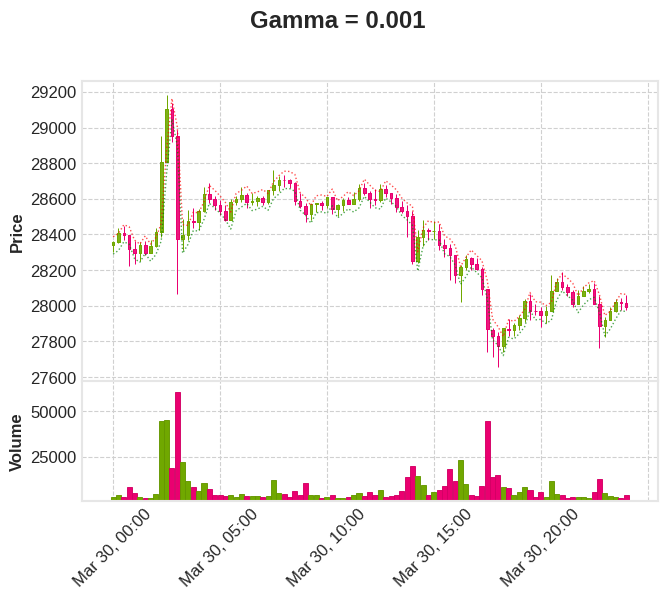

In [55]:
import pandas as pd
import mplfinance as mpf

df_timebar_pd = df_timebar.to_pandas()
df_timebar_pd["timestamp"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.set_index("timestamp")
df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index >= "2023-3-30") & (df_timebar_pd.index <= "2023-3-31")]

display(df_timebar_pd_filtered)

apdict = [
    mpf.make_addplot(df_timebar_pd_filtered["Open"] + df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='red', linestyle=':', width=1, alpha=0.7),
    mpf.make_addplot(df_timebar_pd_filtered["Open"] - df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='green', linestyle=':', width=1, alpha=0.7),
]
mpf.plot(df_timebar_pd_filtered, type='candle', addplot=apdict, volume=True, style='binance', figscale=1.0, figsize=(8, 6), title=f"Gamma = {gamma}")
plt.show()

In [ ]:
plt.plot(df_timebar["timestamp"], df_timebar["open"], label="open")
plt.plot(df_timebar["timestamp"], df_timebar["close"], label="close")
plt.plot(df_timebar["timestamp"], df_timebar["open"] + df_timebar["delta_b_delta_a"] / 2, label="ask")
plt.plot(df_timebar["timestamp"], df_timebar["open"] - df_timebar["delta_b_delta_a"] / 2, label="bid")
plt.xlim(1678406400000, 1678406400000 + 15 * 60 * 1000 * 10)
plt.ylim(19500, 20500)
plt.legend()